In [83]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import pandas as pd

# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

# A simple little 2D matrix plotter, excluding x and y labels.
def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    
def Hankelise(X):
    """
    Hankelises the matrix X, returning H(X).
    """
    L, K = X.shape
    transpose = False
    if L > K:
        # The Hankelisation below only works for matrices where L < K.
        # To Hankelise a L > K matrix, first swap L and K and tranpose X.
        # Set flag for HX to be transposed before returning. 
        X = X.T
        L, K = K, L
        transpose = True

    HX = np.zeros((L,K))
    
    # I know this isn't very efficient...
    for m in range(L):
        for n in range(K):
            s = m+n
            if 0 <= s <= L-1:
                for l in range(0,s+1):
                    HX[m,n] += 1/(s+1)*X[l, s-l]    
            elif L <= s <= K-1:
                for l in range(0,L-1):
                    HX[m,n] += 1/(L-1)*X[l, s-l]
            elif K <= s <= K+L-2:
                for l in range(s-K+1,L):
                    HX[m,n] += 1/(K+L-s-1)*X[l, s-l]
    if transpose:
        return HX.T
    else:
        return HX
    
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)
        

In [3]:
sales_of_company_x = pd.read_csv("monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("daily-total-female-births-in-cal.csv")

### Продажи компании Х

РАссмотрим ВР про продажи, который имеет тренд и сезонность

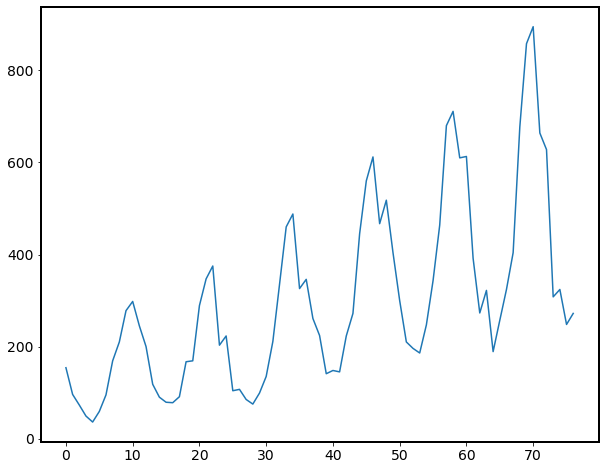

In [41]:
plt.plot(sales_of_company_x['Count'])

In [285]:
F = sales_of_company_x['Count']

N = len(F)
L = 30 # The window length.
K = N - L + 1 # The number of columns in the trajectory matrix.
# Create the trajectory matrix by pulling the relevant subseries of F, and stacking them as columns.
X = np.column_stack([F[i:i+L] for i in range(0,K)])
# Note: the i+L above gives us up to i+L-1, as numpy array upper bounds are exclusive. 

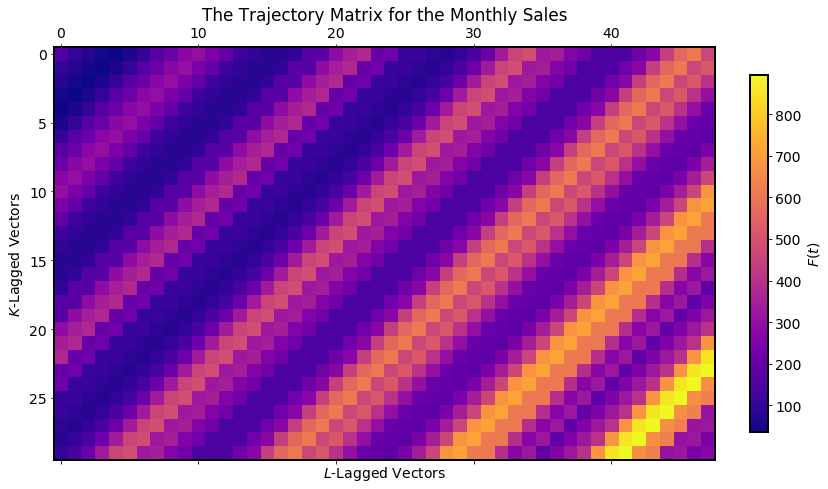

In [286]:
ax = plt.matshow(X)
plt.xlabel("$L$-Lagged Vectors")
plt.ylabel("$K$-Lagged Vectors")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title("The Trajectory Matrix for the Monthly Sales");

Выполним сигнулярное разложение и отобразим элементарные матрицы Fx.

In [287]:
d = np.linalg.matrix_rank(X) 

U, Sigma, V = np.linalg.svd(X)
V = V.T 
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")

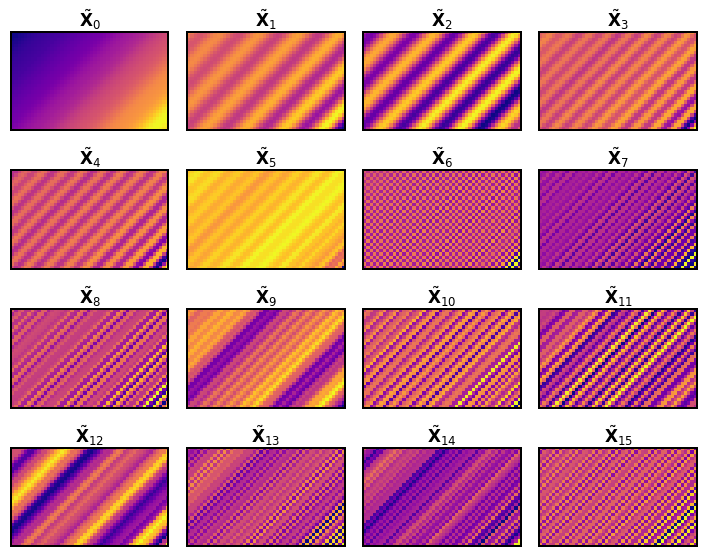

In [35]:
#n = min(8, d)
#for i in range(n):
#    plt.subplot(4,4,i+1)
#    title = "$\mathbf{X}_{" + str(i) + "}$"
#    plot_2d(X_elem[i], title)
#plt.tight_layout()

n = min(d, 16)
for j in range(0,n):
    plt.subplot(4,4,j+1)
    title = r"$\tilde{\mathbf{X}}_{" + str(j) + "}$"
    plot_2d(Hankelise(X_elem[j]), title)
plt.tight_layout() 

Выше из элеменарных матриц видно, что:
 - X0 - изменяется медленно, значит это скорее всего тренд
 - X2,3 - одинаковы по периоду и форме, чередуются. значит это первый сезонный комонент
 - x3,4,5 - аналогично пункту выше имеют более длинный период, значит их можно объединить во второй сезонный компонент
 - X12, X9 - похожи, но имею более сложну форму, нежели синусоида. объединим их в третий сезоый компонент и посмотрим как он повлияет на повторяемость формы оригинального ВР
 
Ниже видно, что матрицы 0-2 на 98% точно описвают ВР и по идее их достаточно для построения модели.

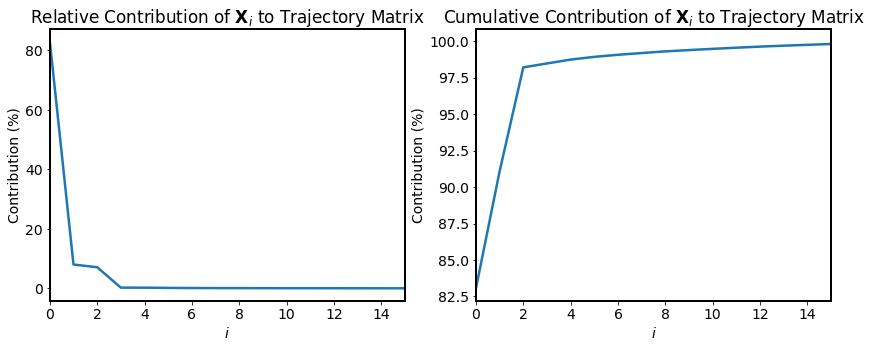

In [37]:
sigma_sumsq = (Sigma**2).sum()
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(Sigma**2 / sigma_sumsq * 100, lw=2.5)
ax[0].set_xlim(0,15)
ax[0].set_title("Relative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[0].set_xlabel("$i$")
ax[0].set_ylabel("Contribution (%)")
ax[1].plot((Sigma**2).cumsum() / sigma_sumsq * 100, lw=2.5)
ax[1].set_xlim(0,15)
ax[1].set_title("Cumulative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("Contribution (%)");

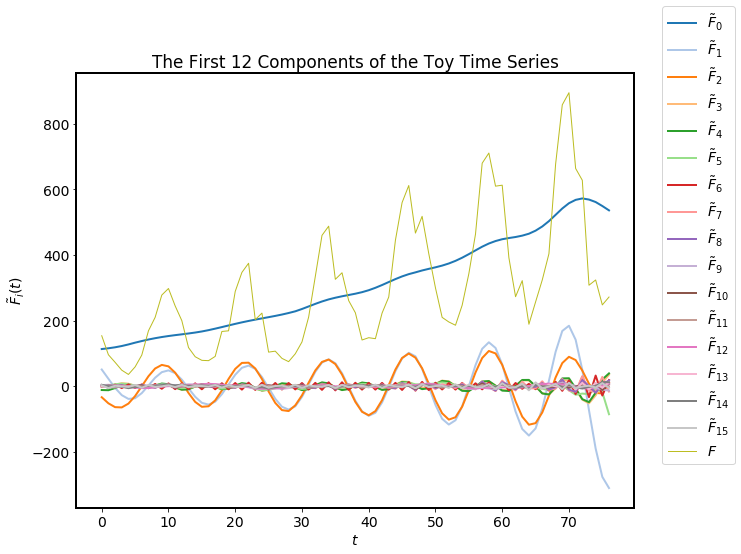

In [38]:
t = np.arange(0,len(F))
n = min(16,d) # In case of noiseless time series with d < 12.

# Fiddle with colour cycle - need more colours!
fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

# Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
for i in range(n):
    F_i = X_to_TS(X_elem[i])
    fig.axes.plot(t, F_i, lw=2)

fig.axes.plot(t, F, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
fig.set_title("The First 12 Components of the Toy Time Series")
fig.legend(legend, loc=(1.05,0.1));

Отобразим отдельные тененции временного ряда: тренд, сезонность1,2,3. Из граика видно, что: 
 - тренд близок к линенйному и имеет легкий изгиб. в самом конце имеет падение вниз, скорее всего связанное с  окончанием ряда.
 - если использовать только первую сезонную компоненту, то ряд немного не точно повторяет верхнюю часть оригинального ВР, но по сути этого уже достаточно, чтобы достаточно близко смоделировь ряд. к тому же компонента 2 достаточно легко может быть описана математически
 - если добавить вторую сезонную компоненту, то ряд лучше приближается о верхам
 - если добавить третью сезонную компоненту, сложну на вид, то появляются точность в ступеньках, но это уже излишне.
 - поэтому остановимся на двух сезонных компонентах
 - остатки визуально выглядят стационарным рядом с переменно дисперсией

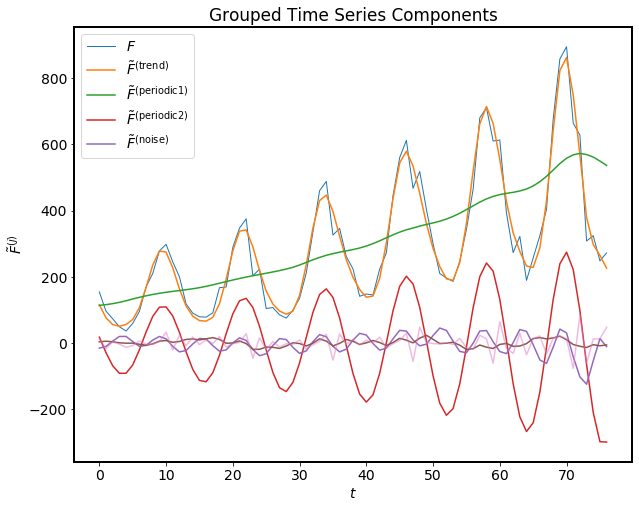

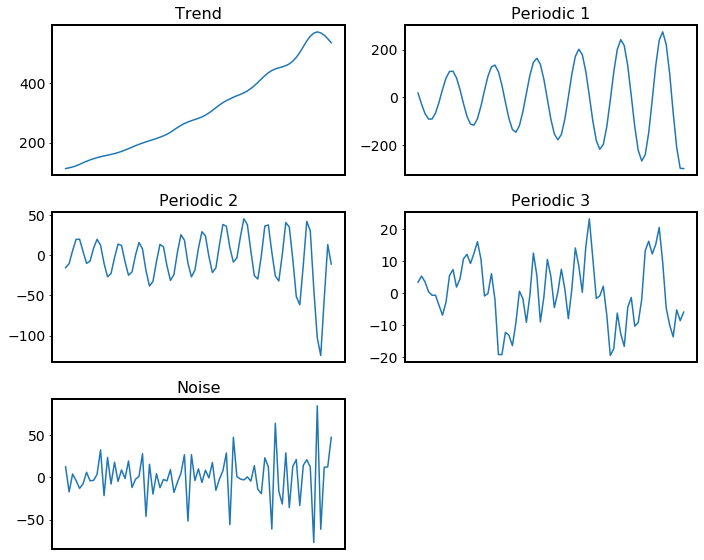

In [73]:
# Assemble the grouped components of the time series.
F_trend = X_to_TS(X_elem[[0]].sum(axis=0))
F_periodic1 = X_to_TS(X_elem[[1,2]].sum(axis=0))
F_periodic2 = X_to_TS(X_elem[[3,4,5]].sum(axis=0))
F_periodic3 = X_to_TS(X_elem[[9,11, 12]].sum(axis=0))
F_noise = X_to_TS(X_elem[[6,7,8,10,13,14,15]].sum(axis=0))

# Plot the toy time series and its separated components on a single plot.
plt.plot(t,F, lw=1)
plt.plot(t,F_trend + F_periodic1 + F_periodic2)
plt.plot(t, F_trend)
plt.plot(t, F_periodic1)
plt.plot(t, F_periodic2)
plt.plot(t, F_periodic3)
plt.plot(t, F_noise, alpha=0.5)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}^{(j)}$")
groups = ["trend", "periodic 1", "periodic 2", "noise"]
legend = ["$F$"] + [r"$\tilde{F}^{(\mathrm{%s})}$"%group for group in groups]
plt.legend(legend)
plt.title("Grouped Time Series Components")
plt.show()

# A list of tuples so we can create the next plot with a loop.
components = [("Trend", F_trend), 
              ("Periodic 1", F_periodic1),
              ("Periodic 2", F_periodic2),
              ("Periodic 3", F_periodic3),
              ("Noise", F_noise)]

# Plot the separated components and original components together.
fig = plt.figure()
n=1
for name, ssa_comp in components:
    ax = fig.add_subplot(3,2,n)
    ax.plot(t, ssa_comp)
    ax.set_title(name, fontsize=16)
    ax.set_xticks([])
    n += 1

fig.tight_layout()

Не смотря на то, что мы визуально оценили выше и сгруппировали матрицы в тренды и сезонность выполним корреляционный анализ

In [74]:
# Get the weights w first, as they'll be reused a lot.
# Note: list(np.arange(L)+1) returns the sequence 1 to L (first line in definition of w), 
# [L]*(K-L-1) repeats L K-L-1 times (second line in w definition)
# list(np.arange(L)+1)[::-1] reverses the first list (equivalent to the third line)
# Add all the lists together and we have our array of weights.
w = np.array(list(np.arange(L)+1) + [L]*(K-L-1) + list(np.arange(L)+1)[::-1])

# Get all the components of the toy series, store them as columns in F_elem array.
F_elem = np.array([X_to_TS(X_elem[i]) for i in range(d)])

# Calculate the individual weighted norms, ||F_i||_w, first, then take inverse square-root so we don't have to later.
F_wnorms = np.array([w.dot(F_elem[i]**2) for i in range(d)])
F_wnorms = F_wnorms**-0.5

# Calculate the w-corr matrix. The diagonal elements are equal to 1, so we can start with an identity matrix
# and iterate over all pairs of i's and j's (i != j), noting that Wij = Wji.
Wcorr = np.identity(d)
for i in range(d):
    for j in range(i+1,d):
        Wcorr[i,j] = abs(w.dot(F_elem[i]*F_elem[j]) * F_wnorms[i] * F_wnorms[j])
        Wcorr[j,i] = Wcorr[i,j]

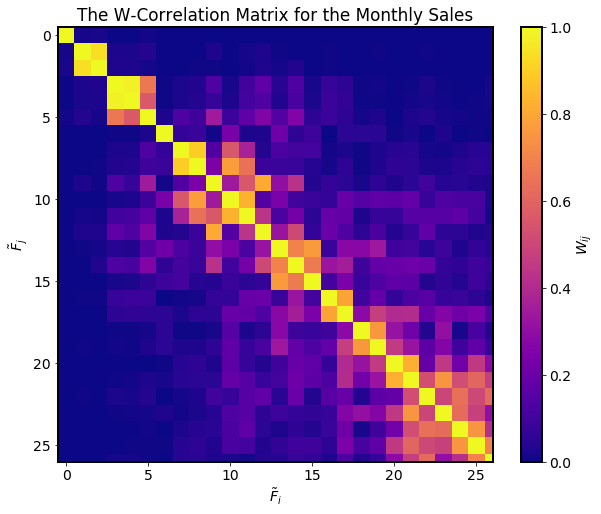

In [82]:
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.clim(0,1)
plt.xlim(-0.5,26)
plt.ylim(26,-0.5)
plt.title("The W-Correlation Matrix for the Monthly Sales");

Окно $L = 2$<a name="Section5.2"></a>


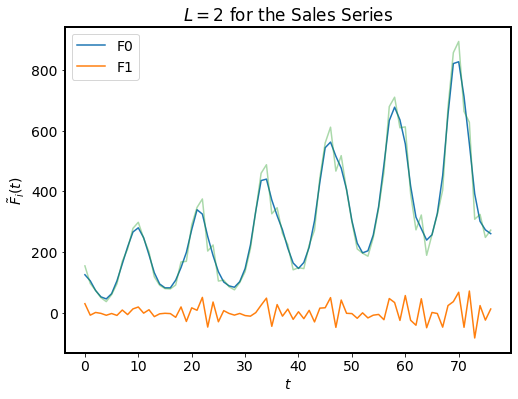

In [99]:
F_sales_L2 = SSA(F, 2)
F_sales_L2.components_to_df().plot()
F_sales_L2.orig_TS.plot(alpha=0.4, figsize=(8, 6))
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=2$ for the Sales Series");

Так как форма ряда достаточно простая, то даже при разделении на две компоненты (полезный график и шум), полезный ряд очень хорошо апроксимирует исходнй ряд.

Окно $L = 5$<a name="Section5.2"></a>

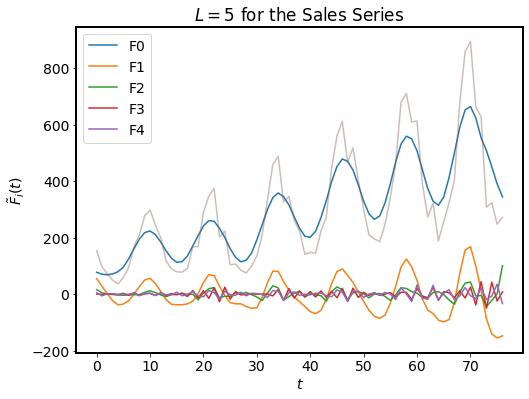

In [101]:
F_sales_L2 = SSA(F, 5)
F_sales_L2.components_to_df().plot()
F_sales_L2.orig_TS.plot(alpha=0.4, figsize=(8, 6))
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=5$ for the Sales Series");

In [134]:
F_ssa_L20.Wcorr

array([[1.00000000e+00, 1.04652268e-02, 1.09851790e-02, ...,
        7.38444531e-05, 8.25211525e-05, 1.06658858e-04],
       [1.04652268e-02, 1.00000000e+00, 9.41311156e-01, ...,
        1.93053189e-04, 5.87047822e-04, 3.16260959e-04],
       [1.09851790e-02, 9.41311156e-01, 1.00000000e+00, ...,
        2.84682459e-04, 8.48413242e-04, 1.47494999e-03],
       ...,
       [7.38444531e-05, 1.93053189e-04, 2.84682459e-04, ...,
        1.00000000e+00, 6.77529945e-01, 5.40272993e-01],
       [8.25211525e-05, 5.87047822e-04, 8.48413242e-04, ...,
        6.77529945e-01, 1.00000000e+00, 5.39064822e-01],
       [1.06658858e-04, 3.16260959e-04, 1.47494999e-03, ...,
        5.40272993e-01, 5.39064822e-01, 1.00000000e+00]])

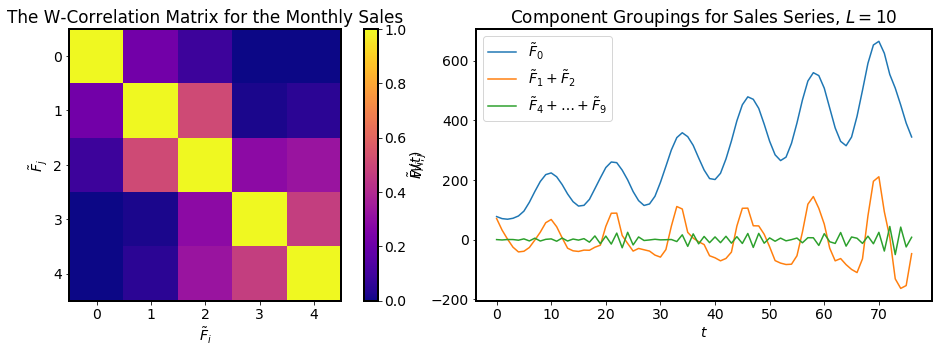

In [267]:
F_sales_L5 = SSA(F, 5)
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
ax = plt.imshow(F_sales_L5.Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{i,j}$")
plt.clim(0,1)
plt.title("The W-Correlation Matrix for the Monthly Sales");

plt.subplot(1, 2, 2)
F_sales_L5.reconstruct(0).plot()
F_sales_L5.reconstruct([1,2]).plot()
F_sales_L5.reconstruct(slice(3,4)).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for Sales Series, $L=10$");
plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1+\tilde{F}_2$", 
            r"$\tilde{F}_4+ \ldots + \tilde{F}_{9}$",
            r"$\tilde{F}_3$"]);


при окне длинной 5 мы уже получаем 2 явных составляющих. Пока тренд нелинеен и нужно добиавать, чтобы он стал линейным. это видно и на матрице корреляций. необходимо увеличить окно, чтобы получить отдельно тренд и сезонность

Окно  𝐿=10

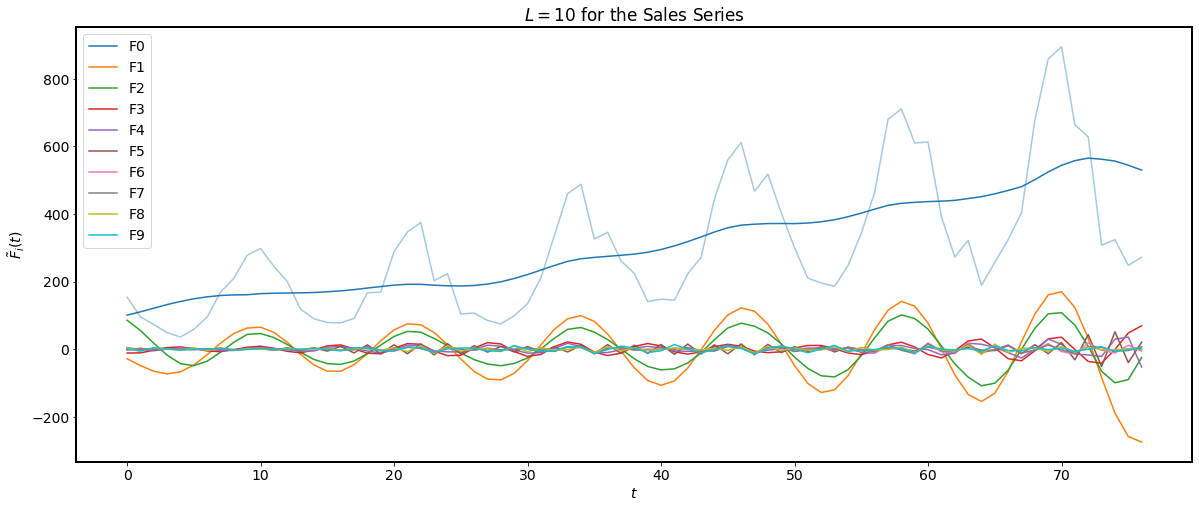

In [195]:
F_sales_L10 = SSA(F, 10)
F_sales_L10.components_to_df().plot()
F_sales_L10.orig_TS.plot(alpha=0.4, figsize=(20, 8))
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=10$ for the Sales Series");

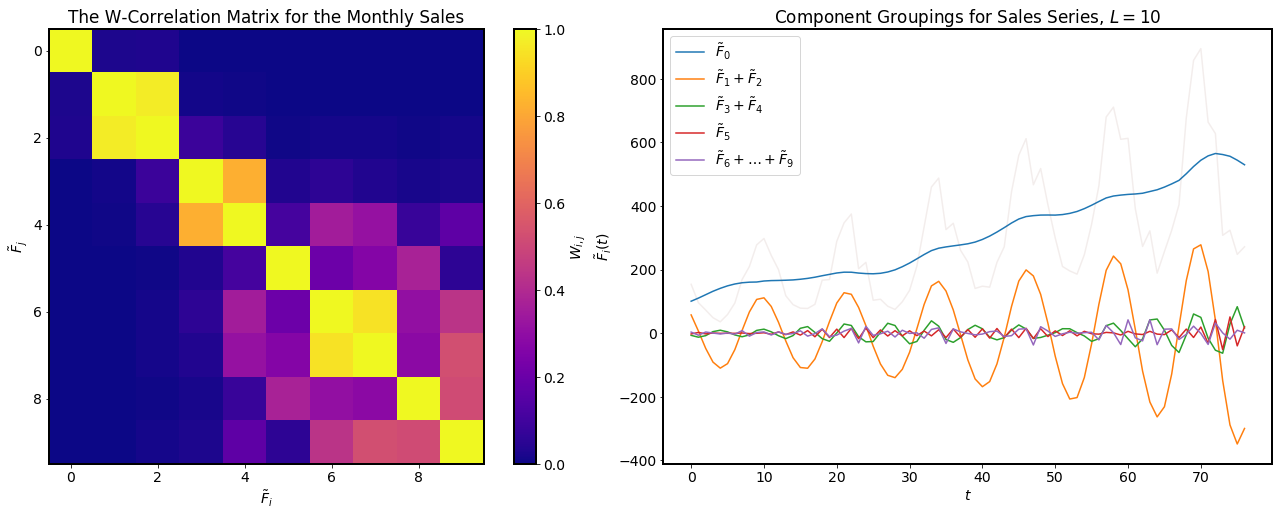

In [268]:
F_sales_L10 = SSA(F, 10)
plt.figure(figsize=(24, 8))

plt.subplot(1, 2, 1)
ax = plt.imshow(F_sales_L10.Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{i,j}$")
plt.clim(0,1)
plt.title("The W-Correlation Matrix for the Monthly Sales");

plt.subplot(1, 2, 2)
F_sales_L10.reconstruct(0).plot()
F_sales_L10.reconstruct([1,2]).plot()
F_sales_L10.reconstruct([3,4]).plot()
F_sales_L10.reconstruct(5).plot()
F_sales_L10.reconstruct(slice(6,9)).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
F_sales_L10.orig_TS.plot(alpha=0.1)
plt.title("Component Groupings for Sales Series, $L=10$");
plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1+\tilde{F}_2$", 
            r"$\tilde{F}_3+\tilde{F}_4$",
            r"$\tilde{F}_5$",
            r"$\tilde{F}_6+ \ldots + \tilde{F}_{9}$",
            ]);

при окне 10 на корреляционной матрице мы видим трендовую составляющую F0, сильную связь:
 - F1,F2 (на графике видно, что это две синусоиды с переменной амплитудой, но одинаковым периодом);
 - F2,F3 (на графике видно, что это две синусоиды с переменной амплитудой (меняется по синусоиде), но одинаковым периодом);
 - F6,F7 (на графике видно, что это две сезонные составляющие с переменной почти одинаковой амплитудой и одинаковым периодом);. при этом есть  связь этих составляющих и с F8, F9, поэтому объединим их в одну о группу.
По графику в явном виде линейный тренд(немного колеблется) и увеличивающуюся со временем по апвлитуде линейную составляющую. эти две сезонные составляющие можно было бы смело объединить и получить одну сезонность. возможно малой корреляции между ними мешают хвосты начала и конца. на мартрице корреляций также очевидны ссвязи между окном 2-3, а также 6-7. причем последняя хорошо корреклирует с 8,9

Окно  𝐿=20

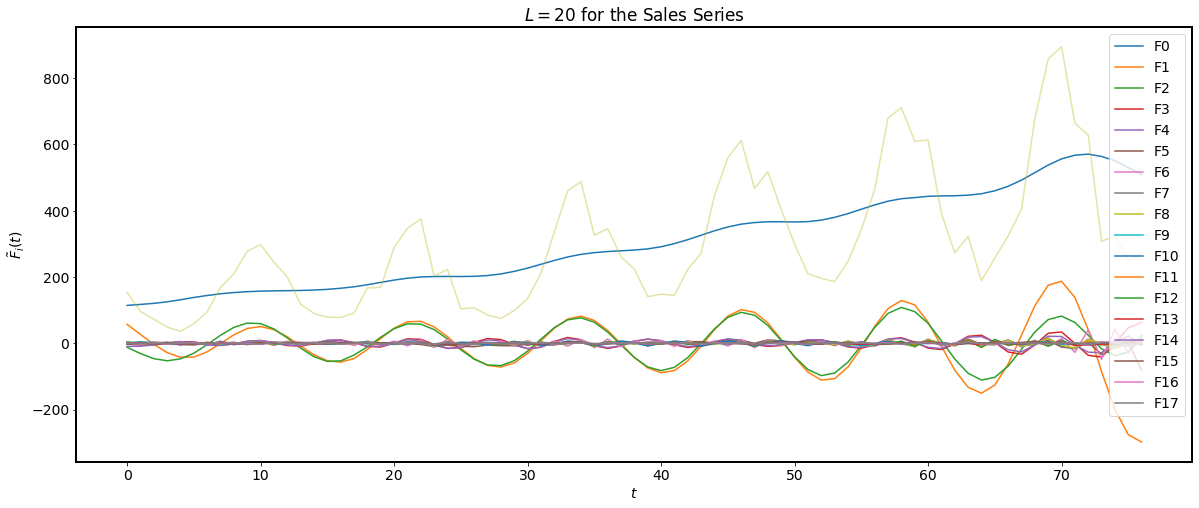

In [194]:
F_sales_L2 = SSA(F, 18)
F_sales_L2.components_to_df().plot()
F_sales_L2.orig_TS.plot(alpha=0.4, figsize=(20, 8))
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=20$ for the Sales Series");

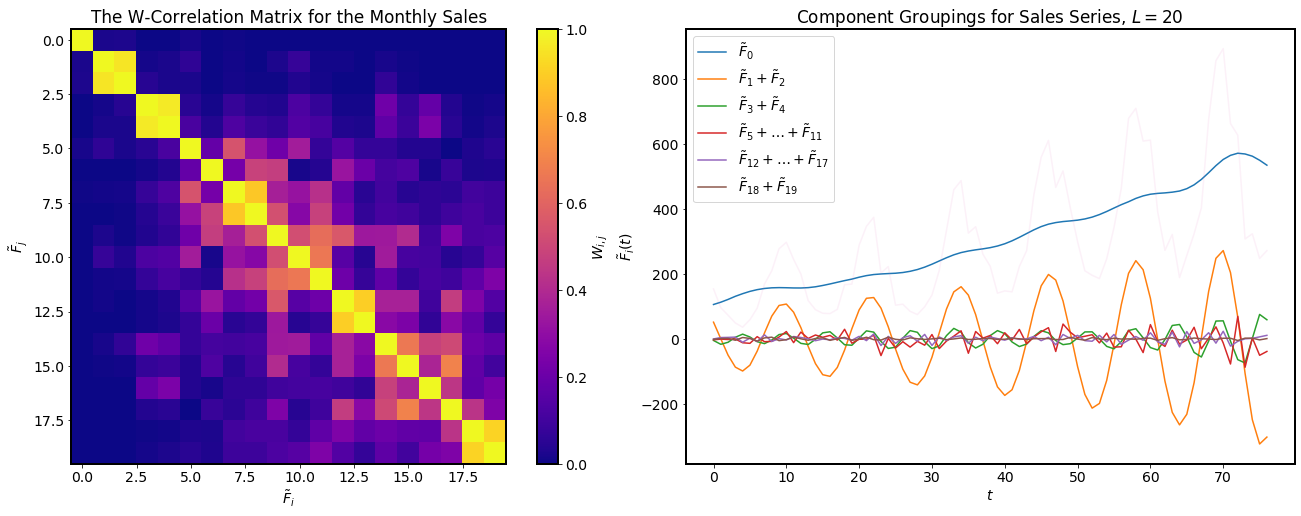

In [269]:
F_sales_L20 = SSA(F, 20)
plt.figure(figsize=(24, 8))

plt.subplot(1, 2, 1)
ax = plt.imshow(F_sales_L20.Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{i,j}$")
plt.clim(0,1)
plt.title("The W-Correlation Matrix for the Monthly Sales");

plt.subplot(1, 2, 2)
F_sales_L20.reconstruct(0).plot()
F_sales_L20.reconstruct([1,2]).plot()
F_sales_L20.reconstruct([3,4]).plot()
F_sales_L20.reconstruct(slice(5,11)).plot()
F_sales_L20.reconstruct(slice(12,17)).plot()
F_sales_L20.reconstruct([18,19]).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
F_sales_L20.orig_TS.plot(alpha=0.1)
plt.title("Component Groupings for Sales Series, $L=20$");
plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1+\tilde{F}_2$", 
            r"$\tilde{F}_3+\tilde{F}_4$",
            r"$\tilde{F}_5+ \ldots + \tilde{F}_{11}$",
            r"$\tilde{F}_{12}+ \ldots + \tilde{F}_{17}$",
            r"$\tilde{F}_{18}+\tilde{F}_{19}$"
            ]);

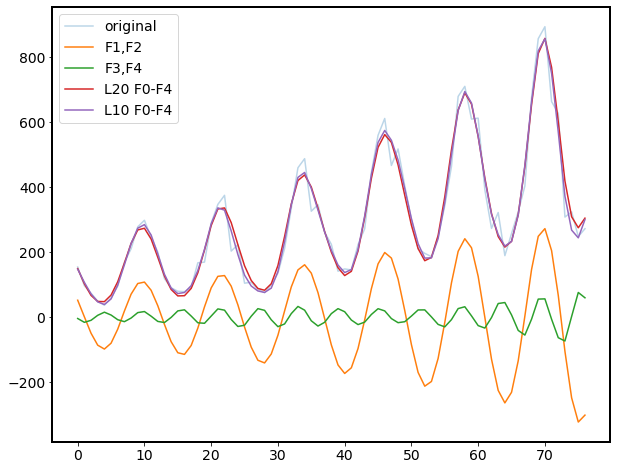

In [261]:
F_sales_L20.orig_TS.plot(alpha=0.3, label = 'original')
F_sales_L20.reconstruct([1,2]).plot(label = 'F1,F2')
F_sales_L20.reconstruct([3,4]).plot(label = 'F3,F4')
#F_sales_L20.reconstruct(slice(0,2)).plot(label = 'F0-F2')
F_sales_L20.reconstruct(slice(0,4)).plot(label = 'L20 F0-F4')
F_sales_L10.reconstruct(slice(0,4)).plot(label = 'L10 F0-F4')
#F_sales_L5.reconstruct(slice(0,4)).plot(label = 'L5 F0-F4')
plt.legend()

при окне 20 мы имеем более линейный тренд и две сезонных составляющих становятся близки по амплитуде и одинаковые по периоду (F1,F2). Все остальные компоненты имеют нулевую среднюю и очень низкую дисперсию. 
На корреляционной матрице видим тренд F0, сильную связь:
 - F1,F2 (на графике видно, что это две синусоиды с переменной амплитудой, но одинаковым периодом);
 - F2,F3 (на графике видно, что это две синусоиды с переменной амплитудой (меняется по синусоиде), но одинаковым периодом);
 - F5-F11 
 - F12-F17
В данно случае также достаточно учитывать только 5 первых компонент, чтобы максимально точно апроксимировать график. хотя апроксимация и хуже, чем в случае с меньшим окном (=> меньшим количеством компонент). Зато отдельные компонент становятся более простыми (тренд более линейным, сезонности с менее изменяющейся дисперсией).

Окно  𝐿=36

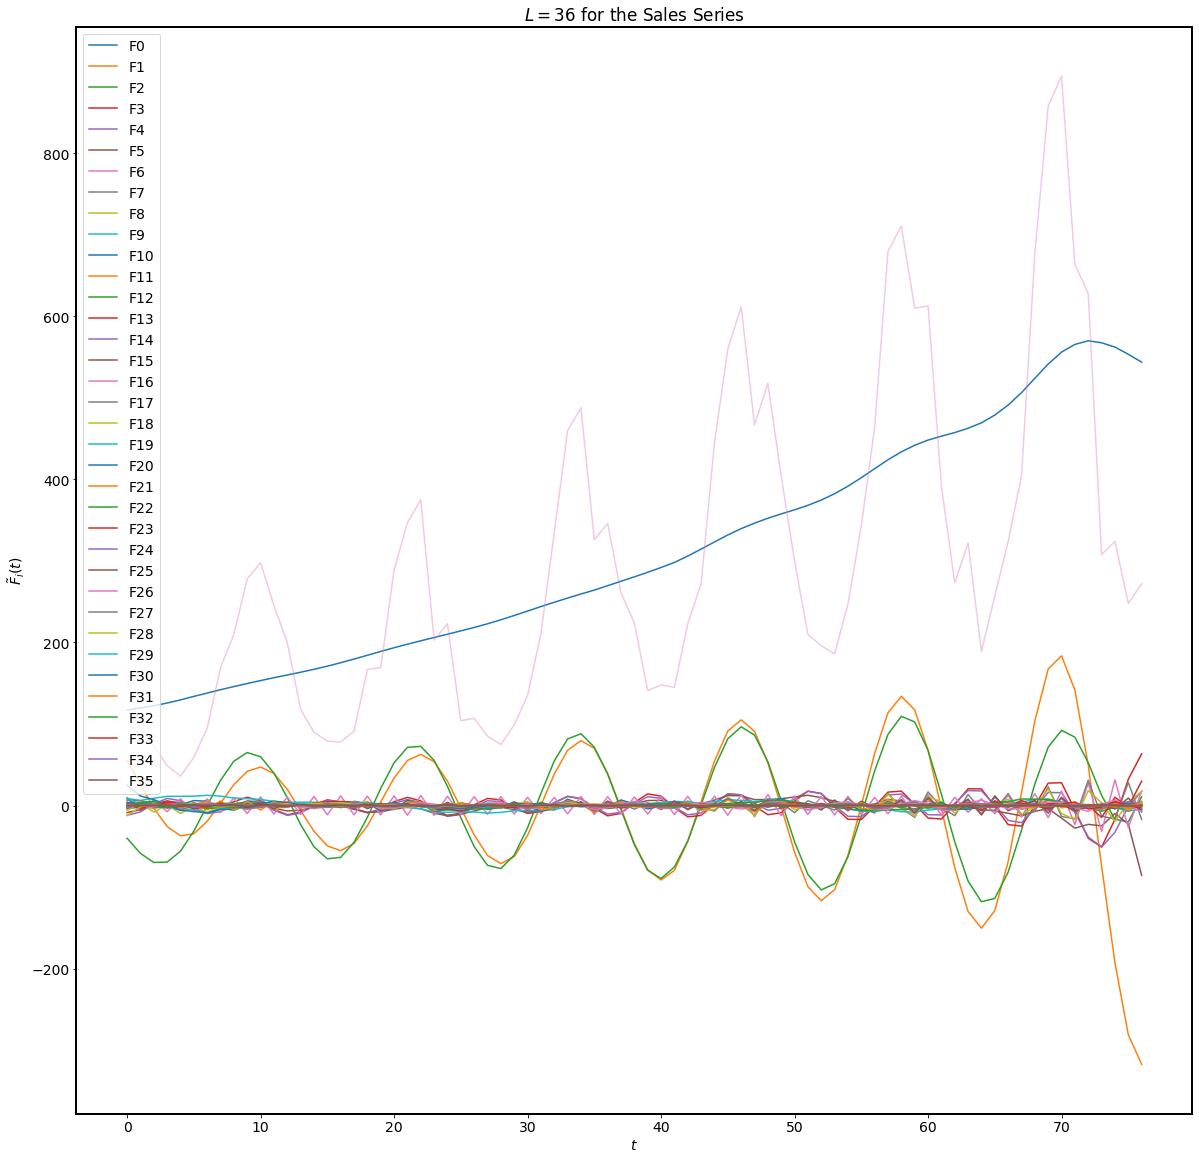

In [264]:
F_sales_L36 = SSA(F, 36)
F_sales_L36.components_to_df().plot()
F_sales_L36.orig_TS.plot(alpha=0.4, figsize=(20, 20))
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=36$ for the Sales Series");

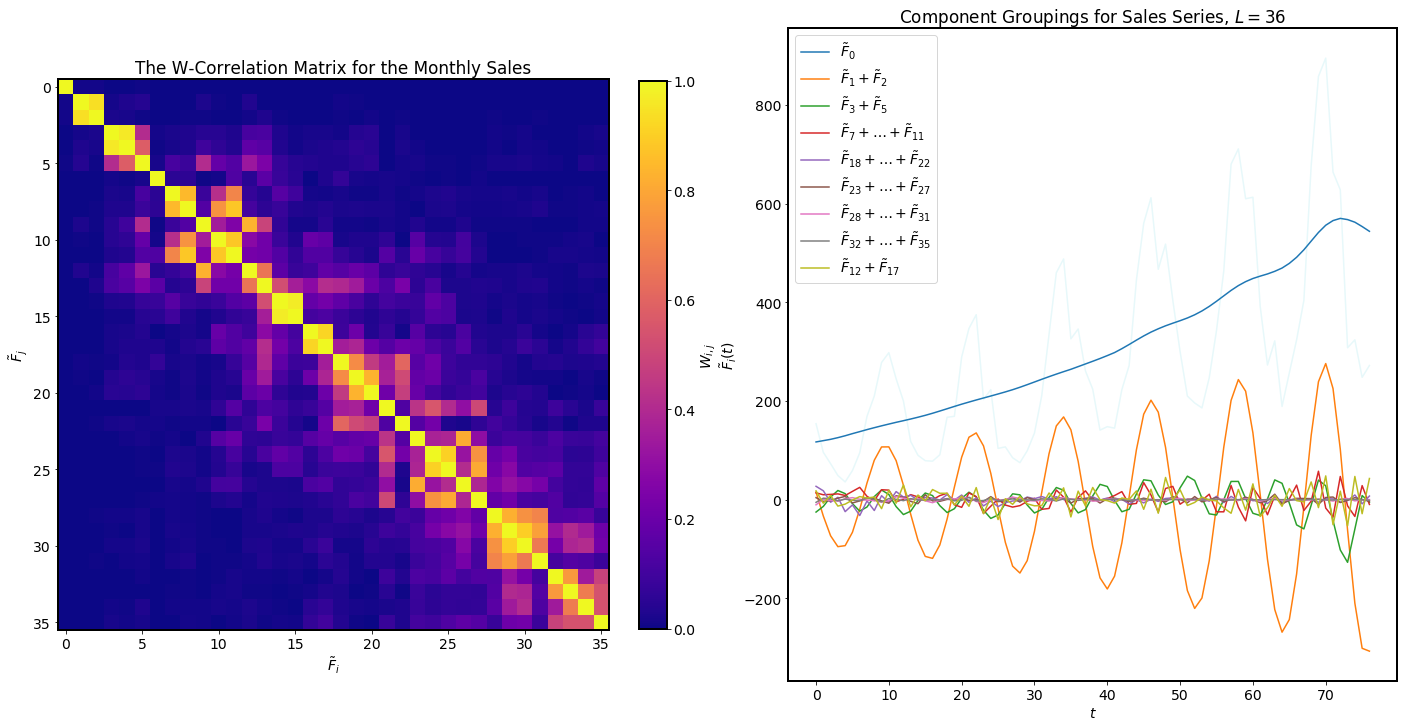

In [271]:
F_sales_L36 = SSA(F, 36)
plt.figure(figsize=(24, 12))

plt.subplot(1, 2, 1)
ax = plt.imshow(F_sales_L36.Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{i,j}$")
plt.clim(0,1)
plt.title("The W-Correlation Matrix for the Monthly Sales");

plt.subplot(1, 2, 2)
F_sales_L36.reconstruct(0).plot()
F_sales_L36.reconstruct([1,2]).plot()
F_sales_L36.reconstruct([3,4,5]).plot()
F_sales_L36.reconstruct(slice(7,11)).plot()
F_sales_L36.reconstruct(slice(18,22)).plot()
F_sales_L36.reconstruct(slice(23,27)).plot()
F_sales_L36.reconstruct(slice(28,31)).plot()
F_sales_L36.reconstruct(slice(32,35)).plot()
F_sales_L36.reconstruct([6,12,13,14,15,16,17]).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
F_sales_L36.orig_TS.plot(alpha=0.1)
plt.title("Component Groupings for Sales Series, $L=36$");
plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1+\tilde{F}_2$", 
            r"$\tilde{F}_3+\tilde{F}_5$",
            r"$\tilde{F}_7+ \ldots + \tilde{F}_{11}$",
            r"$\tilde{F}_{18}+ \ldots + \tilde{F}_{22}$",
            r"$\tilde{F}_{23}+ \ldots + \tilde{F}_{27}$",
            r"$\tilde{F}_{28}+ \ldots + \tilde{F}_{31}$",
            r"$\tilde{F}_{32}+ \ldots + \tilde{F}_{35}$",
            r"$\tilde{F}_{12}+\tilde{F}_{17}$"
            ]);

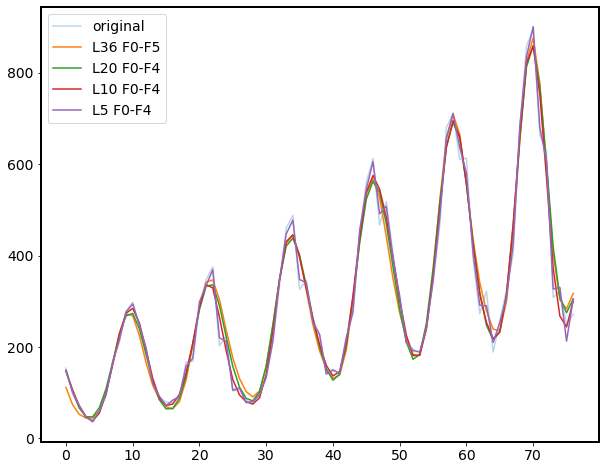

In [278]:
F_sales_L36.orig_TS.plot(alpha=0.3, label = 'original')
#F_sales_L36.reconstruct([1,2]).plot(label = 'F1,F2')
#F_sales_L36.reconstruct([3,4]).plot(label = 'F3,F4')
#F_sales_L36.reconstruct(slice(0,2)).plot(label = 'F0-F2')
F_sales_L36.reconstruct(slice(0,5)).plot(label = 'L36 F0-F5')
F_sales_L20.reconstruct(slice(0,4)).plot(label = 'L20 F0-F4')
F_sales_L10.reconstruct(slice(0,4)).plot(label = 'L10 F0-F4')
F_sales_L5.reconstruct(slice(0,4)).plot(label = 'L5 F0-F4')
plt.legend()

при окне 36(максимально L<=N/2) мы имеем более сглаженный тренд, но он становится более нелинейным (квдратичным) 
На корреляционной матрице видим тренд F0, сильную связь:
 - F1,F2 (на графике видно, что это две синусоиды с переменной амплитудой, но одинаковым периодом);
 - F3-F5 (на графике видно, что это две синусоиды с переменной амплитудой (меняется по синусоиде), но одинаковым периодом);
 - F7-F11 
 - F12-F17
 - F18-F22
 - F23-F27
 - F28-F31
 - F32-F35

В данном случае также достаточно учитывать только 6 первых компонент, чтобы максимально точно апроксимировать график. хотя апроксимация и хуже, чем в случае с меньшим окном (=> меньшим количеством компонент). Зато отдельные компонент становятся более простыми (тренд более линейным, сезонности с менее изменяющейся дисперсией).

На мой взгляд достаточно окна 10 и первых 5 компонент, чтобы достаточно точно апроксимировать график

### Индекс Доу-Джонса

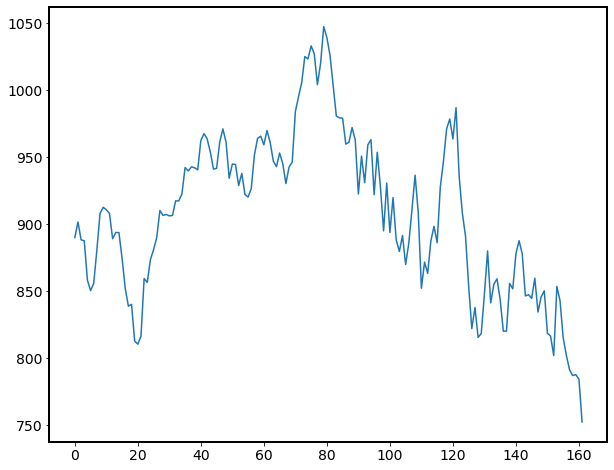

In [288]:
F = pd.read_csv("weekly-closings-of-the-dowjones-.csv")['Close']
plt.plot(F)

посмотрим, сколько потребуется компонентов, чтобы такой ряд отобразить. видим, что 99% отражает первый компонент, что довольно таки странно.

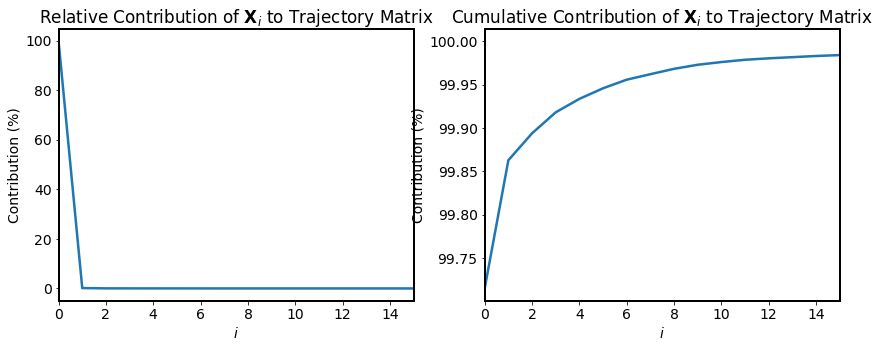

In [289]:
N = len(F)
L = 80 # The window length.
K = N - L + 1 # The number of columns in the trajectory matrix.
# Create the trajectory matrix by pulling the relevant subseries of F, and stacking them as columns.
X = np.column_stack([F[i:i+L] for i in range(0,K)])
# Note: the i+L above gives us up to i+L-1, as numpy array upper bounds are exclusive. 

d = np.linalg.matrix_rank(X) 

U, Sigma, V = np.linalg.svd(X)
V = V.T 
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")

sigma_sumsq = (Sigma**2).sum()
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(Sigma**2 / sigma_sumsq * 100, lw=2.5)
ax[0].set_xlim(0,15)
ax[0].set_title("Relative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[0].set_xlabel("$i$")
ax[0].set_ylabel("Contribution (%)")
ax[1].plot((Sigma**2).cumsum() / sigma_sumsq * 100, lw=2.5)
ax[1].set_xlim(0,15)
ax[1].set_title("Cumulative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("Contribution (%)");

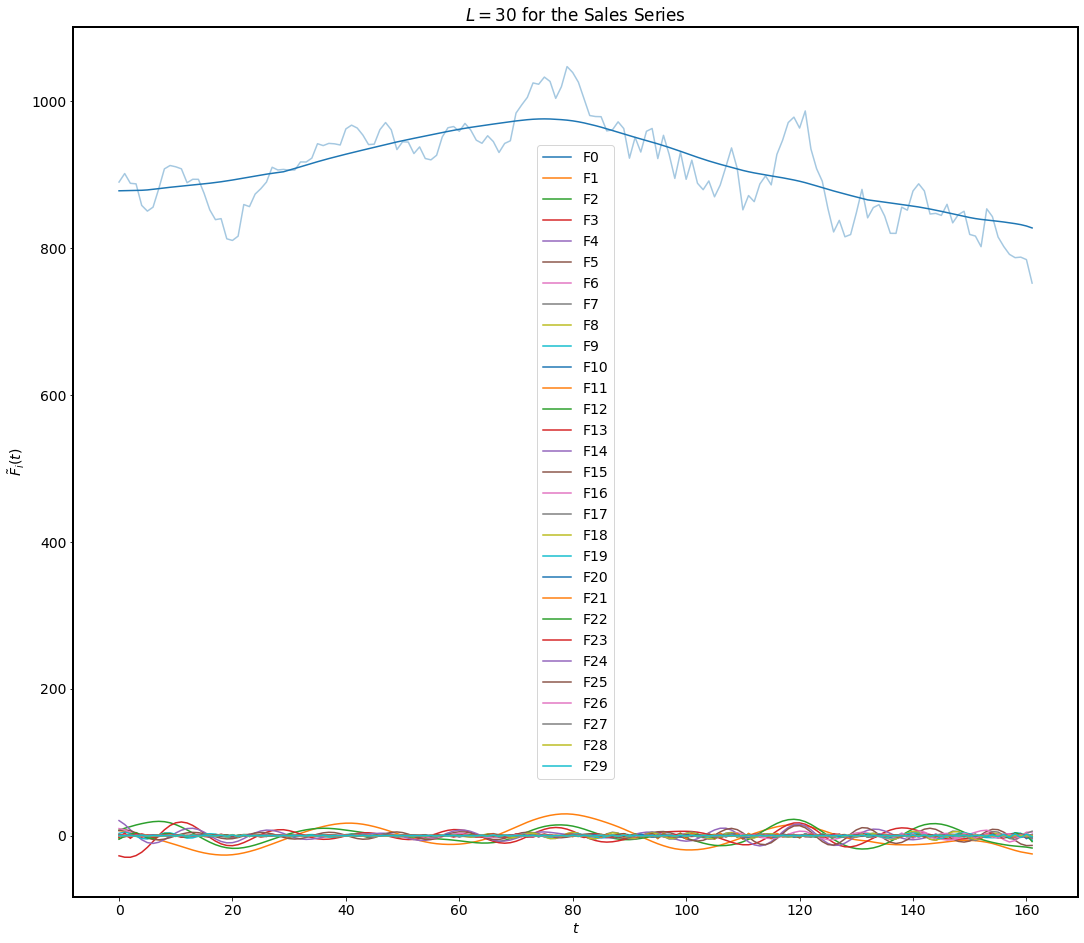

In [378]:
F_dj_L30 = SSA(F, 30)
F_dj_L30.components_to_df().plot()
F_dj_L30.orig_TS.plot(alpha=0.4, figsize=(18, 16))
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=30$ for the Sales Series");

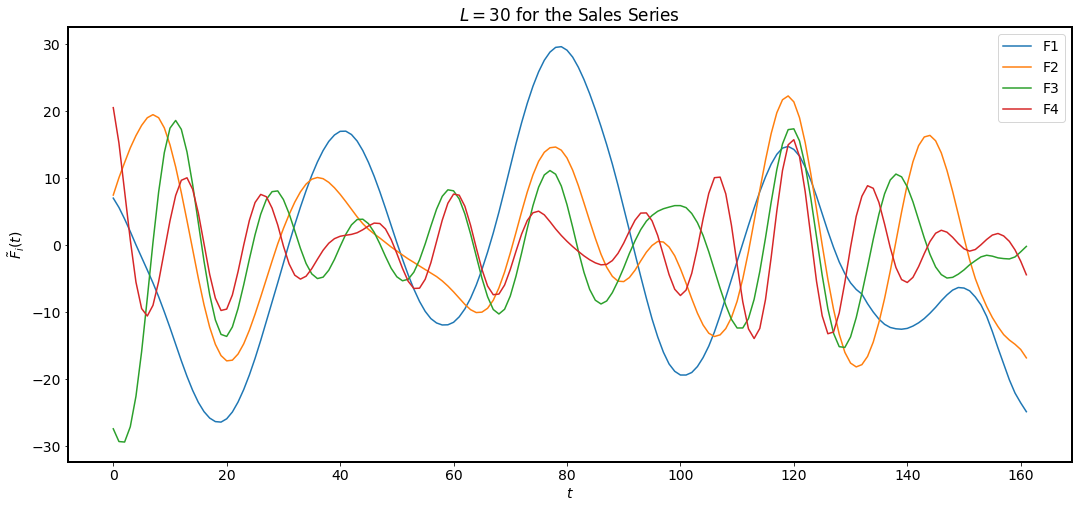

In [380]:
F_dj_L30 = SSA(F, 30)
cols = list(F_dj_L30.components_to_df().columns[1:5])
F_dj_L30.components_to_df()[cols].plot(figsize=(18, 8))
#F_dj_L30.orig_TS.plot(alpha=0.4, figsize=(8, 6))
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=30$ for the Sales Series");

как видим нет каких-то явных графиков синуса, но они имеют более сложную структуру. Если продолжаем увеличивать окно, то компоненты также имеют более сложнную форму, но при этом график тренда все хужеи хуже улавливает  тренд ВР.

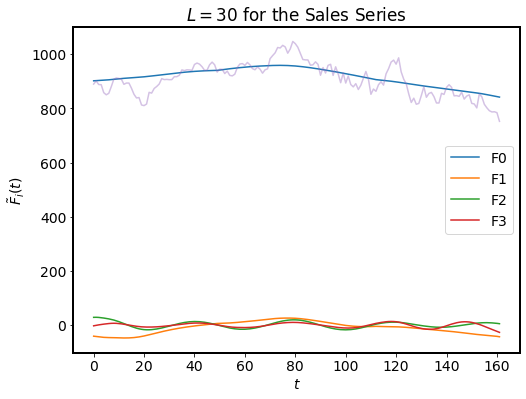

In [365]:
F_dj_L50 = SSA(F, 50)
cols = list(F_dj_L50.components_to_df().columns[0:4])
F_dj_L50.components_to_df()[cols].plot()
F_dj_L50.orig_TS.plot(alpha=0.4, figsize=(8, 6))
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=30$ for the Sales Series");

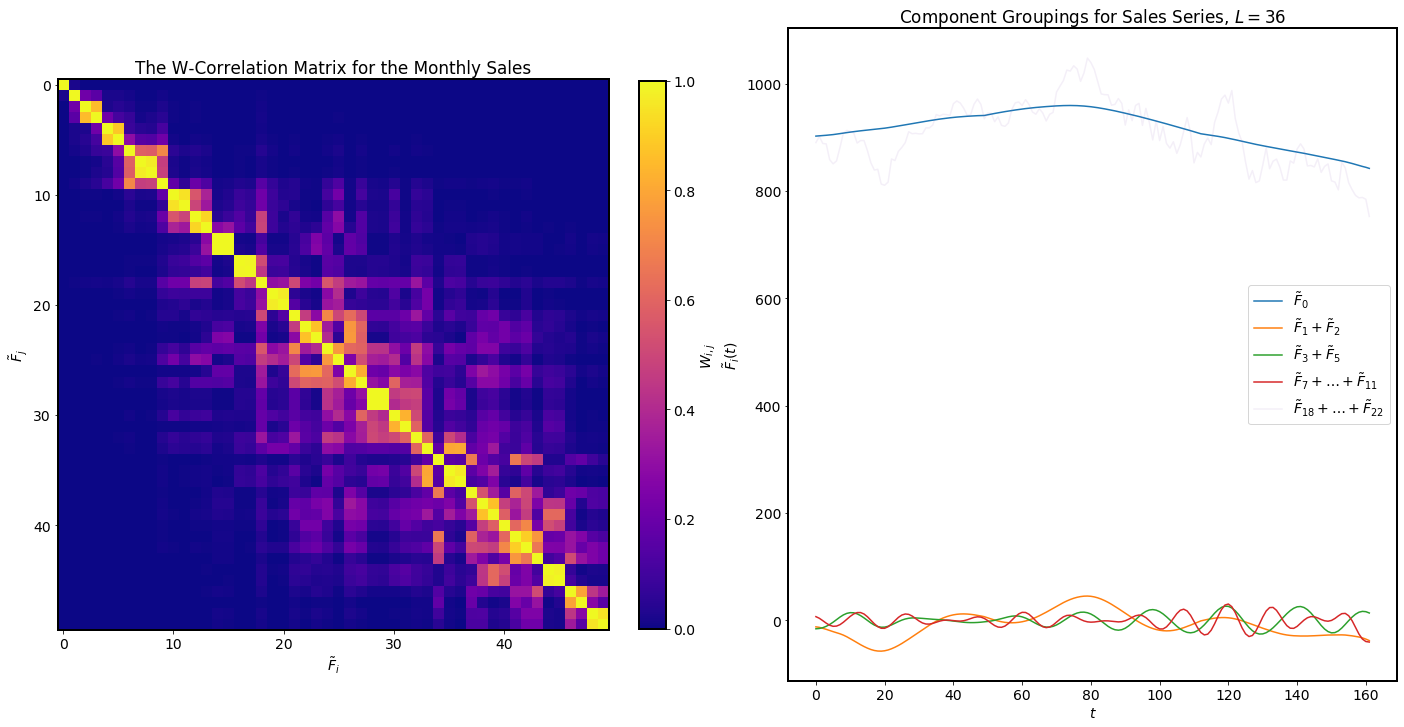

In [327]:
F_dj_L50 = SSA(F, 50)
plt.figure(figsize=(24, 12))

plt.subplot(1, 2, 1)
ax = plt.imshow(F_dj_L50.Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{i,j}$")
plt.clim(0,1)
plt.title("The W-Correlation Matrix for the Monthly Sales");

plt.subplot(1, 2, 2)
F_dj_L50.reconstruct(0).plot()
F_dj_L50.reconstruct(slice(1,3)).plot()
F_dj_L50.reconstruct([4,5]).plot()
F_dj_L50.reconstruct(slice(6,9)).plot()
#F_dj_L50.reconstruct(slice(18,22)).plot()
#F_dj_L50.reconstruct(slice(23,27)).plot()
#F_dj_L50.reconstruct(slice(28,31)).plot()
#F_dj_L50.reconstruct(slice(32,35)).plot()
#F_dj_L50.reconstruct([6,12,13,14,15,16,17]).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
F_dj_L50.orig_TS.plot(alpha=0.1)
plt.title("Component Groupings for Sales Series, $L=36$");
plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1+\tilde{F}_2$", 
            r"$\tilde{F}_3+\tilde{F}_5$",
            r"$\tilde{F}_7+ \ldots + \tilde{F}_{11}$",
            r"$\tilde{F}_{18}+ \ldots + \tilde{F}_{22}$",
            r"$\tilde{F}_{23}+ \ldots + \tilde{F}_{27}$",
            r"$\tilde{F}_{28}+ \ldots + \tilde{F}_{31}$",
            r"$\tilde{F}_{32}+ \ldots + \tilde{F}_{35}$",
            r"$\tilde{F}_{12}+\tilde{F}_{17}$"
            ]);

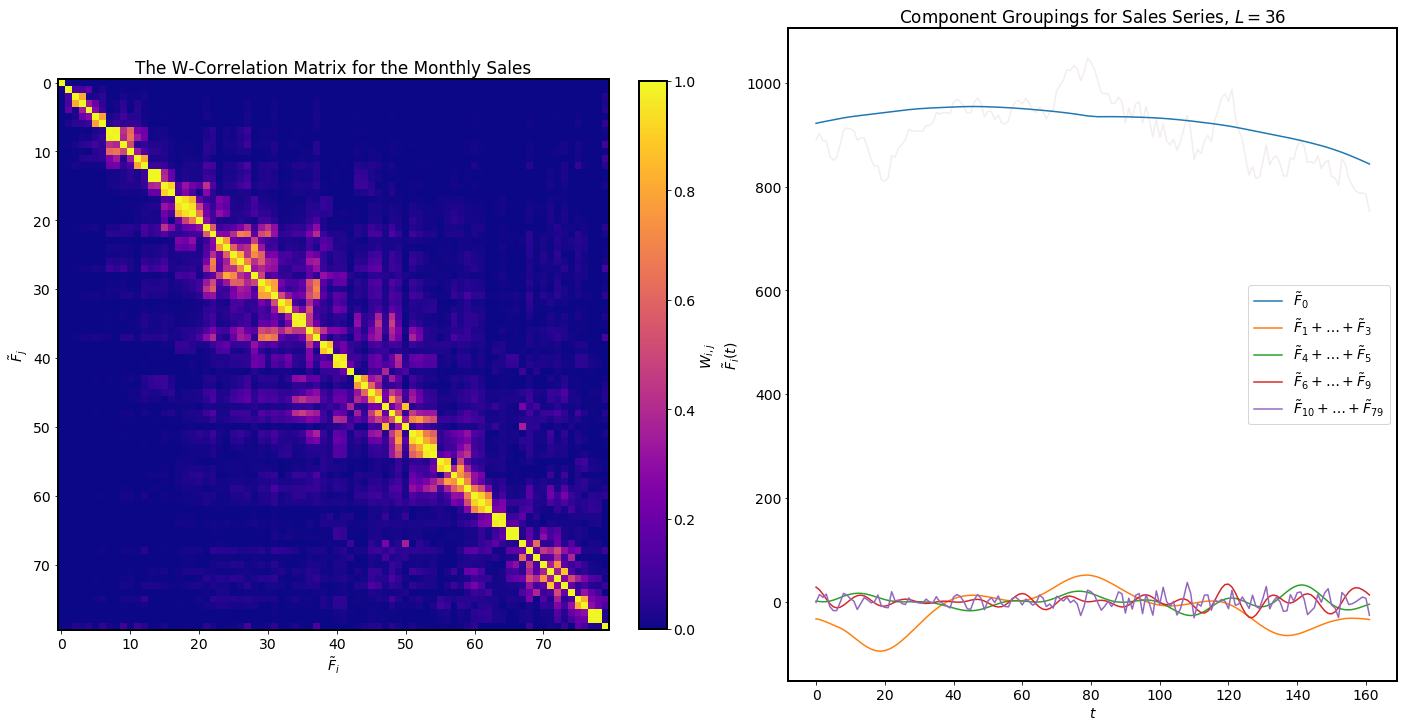

In [381]:
F_dj_L80 = SSA(F, 80)
plt.figure(figsize=(24, 12))

plt.subplot(1, 2, 1)
ax = plt.imshow(F_dj_L80.Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{i,j}$")
plt.clim(0,1)
plt.title("The W-Correlation Matrix for the Monthly Sales");

plt.subplot(1, 2, 2)
F_dj_L80.reconstruct(0).plot()
F_dj_L80.reconstruct(slice(1,3)).plot()
F_dj_L80.reconstruct([4,5]).plot()
F_dj_L80.reconstruct(slice(6,9)).plot()
F_dj_L50.reconstruct(slice(10,79)).plot()

plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
F_dj_L80.orig_TS.plot(alpha=0.1)
plt.title("Component Groupings for Sales Series, $L=36$");
plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_{1}+ \ldots + \tilde{F}_{3}$",
            r"$\tilde{F}_{4}+ \ldots + \tilde{F}_{5}$",
            r"$\tilde{F}_{6}+ \ldots + \tilde{F}_{9}$",
            r"$\tilde{F}_{10}+ \ldots + \tilde{F}_{79}$"
            ]);

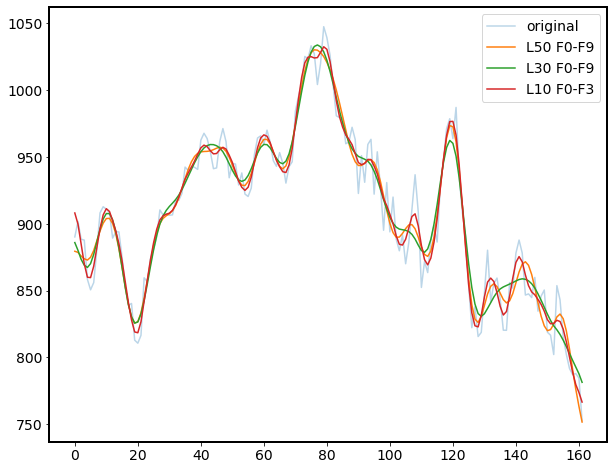

In [392]:
F_dj_L50.orig_TS.plot(alpha=0.3, label = 'original')
#F_dj_L80.reconstruct(slice(0,9)).plot(label = 'L80 F0-F9')
F_dj_L50.reconstruct(slice(0,9)).plot(label = 'L50 F0-F9')
F_dj_L30.reconstruct(slice(0,5)).plot(label = 'L30 F0-F9')
F_dj_L10.reconstruct(slice(0,3)).plot(label = 'L10 F0-F3')
plt.legend()

Вывод: оптимальный размер окна не более 30, так как тренд начинает теряться. для неплохой апроксимации достаточно:
 - L=10 -> 4 первые компоненты
 - L=30 -> 6 первые компоненты (предпочтителе)
 - L=80 -> 9 первые компоненты
в этом случа большая часть шумов убирается.